In [1]:
!tar -xf resistors.tar.xz

In [2]:
import cv2
import pandas as pd
import os
import colorsys
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks, savgol_filter
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [3]:
def get_points(img):
    # Convert to grayscale and process to obtain a binary edge image.
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    gray_blur = cv2.GaussianBlur(gray, (5, 5), 0)
    th = cv2.threshold(gray_blur, 25, 255, cv2.THRESH_BINARY)[1]

    # Find pixel locations where the thresholded image is 255.
    ys, xs = np.where(th == 255)
    points = np.column_stack((xs, ys))   # each point as (x, y)

    # Center the data and compute the covariance matrix.
    mean = points.mean(axis=0)  # shape (2,)
    pts_centered = points - mean
    cov = np.cov(pts_centered, rowvar=False)

    # Compute the eigenvectors and select the one with the largest eigenvalue.
    eigenvalues, eigenvectors = np.linalg.eigh(cov)
    principal_vec = eigenvectors[:, np.argmax(eigenvalues)]
    
    # Define the line endpoints along the principal direction.
    length = max(img.shape)  # large enough to span the image
    x0, y0 = mean
    dx, dy = principal_vec  # principal direction components

    # Endpoints of the line (floating-point)
    x1, y1 = x0 - dx * length, y0 - dy * length
    x2, y2 = x0 + dx * length, y0 + dy * length

    # Convert to integer pixel coordinates and clip to image boundaries.
    h, w = img.shape[:2]
    r1, c1 = int(round(y1)), int(round(x1))
    r2, c2 = int(round(y2)), int(round(x2))
    r1, c1 = np.clip([r1, c1], [0, 0], [h-1, w-1])
    r2, c2 = np.clip([r2, c2], [0, 0], [h-1, w-1])
    
    # Use linear interpolation to get sample points along the line.
    num = int(np.hypot(r2 - r1, c2 - c1))
    sample_cols = np.linspace(c1, c2, num)
    sample_rows = np.linspace(r1, r2, num)

    # Preprocess image: convert BGR to RGB, then apply CLAHE to L channel.
    rgb_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    rgb_img = cv2.GaussianBlur(rgb_img, (5, 5), 0)  # optional additional blur

    # Convert the color image to LAB, apply CLAHE to L and convert back.
    lab_img = cv2.cvtColor(rgb_img, cv2.COLOR_RGB2LAB)
    l, a, b = cv2.split(lab_img)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    l2 = clahe.apply(l)
    lab2 = cv2.merge((l2, a, b))
    out_color = cv2.cvtColor(lab2, cv2.COLOR_LAB2RGB)

    # Compute the perpendicular direction. For (dx, dy), a perpendicular vector is (-dy, dx).
    perp_vec = np.array([-dy, dx])  # already normalized if principal_vec is normalized

    # Prepare a list to collect the mean color at each sample point.
    averaged_samples = []

    # For each sample point along the principal axis, sample pixels along the perpendicular.
    # We'll gather 3 points on either side (+ the center = 7 total).
    num_side = 3  # 3 on each side
    for col, row in zip(sample_cols, sample_rows):
        # Initialize a list to collect the neighboring pixel colors.
        neighborhood = []
        # For offsets from -3 to +3 along the perpendicular:
        for offset in range(-num_side, num_side+1):
            # Compute the offset; note: (x, y) corresponds to (col, row)
            x_offset = col + offset * perp_vec[0]
            y_offset = row + offset * perp_vec[1]
            # Round and clip to valid pixel indices.
            x_idx = int(round(x_offset))
            y_idx = int(round(y_offset))
            x_idx = np.clip(x_idx, 0, w-1)
            y_idx = np.clip(y_idx, 0, h-1)
            # Sample the color at this location.
            neighborhood.append(out_color[y_idx, x_idx].astype(np.float32))
        # Compute the mean color for the neighborhood.
        mean_color = np.mean(neighborhood, axis=0)
        averaged_samples.append(mean_color.astype(np.uint8))

    # Convert to an array; shape (num_samples, 3)
    sampled_colors = np.array(averaged_samples)

    return sampled_colors

In [4]:
def vibrance(r, g, b):
    r_norm, g_norm, b_norm = r / 255.0, g / 255.0, b / 255.0
    _, s, _ = colorsys.rgb_to_hsv(r_norm, g_norm, b_norm)
    return s

def objective(x, y, alpha=5.0):
    denom = x + y
    if denom == 0:
        return 0
    ratio = abs(x - y) / denom
    return x * y * np.exp(-alpha * ratio)

def smoothen(sampled_colors, window_size=5):
    smoothed = np.copy(sampled_colors).astype(float)
    for channel in range(3):
        smoothed[:, channel] = np.convolve(sampled_colors[:, channel].astype(float), np.ones(window_size)/window_size, mode='same')
    return smoothed

def select(samples, peaks, properties):
    take = []
    used = [0 for _ in range(len(peaks))]
    
    def visit(z):
        if 0 <= z < len(peaks):
            used[z] = 1
            
    for i in range(1, len(peaks)):
        if used[i] or used[i - 1]: continue
        m = (peaks[i] + peaks[i - 1]) // 2
        if vibrance(*samples[m]) > 0.4:
            used[i] = used[i - 1] = 1
            take.append((samples[m], peaks[i - 1], peaks[i]))
    last = -1
    for i in range(len(peaks)):
        if not used[i]: continue
        if last == -1:
            last = i
            continue
        if i - last > 2:
            for j in range(last + 1, i, 2):
                m = (peaks[j] + peaks[j + 1]) // 2
                visit(j); visit(j + 1)
                take.append((samples[m], peaks[j], peaks[j + 1]))
        last = i
    heights = properties['peak_heights']
    while len(take) < 5:
        cand, last = [], -1
        for i in range(len(peaks) + 1):
            if i < len(peaks) and not used[i]: continue
            if i - last > 2:
                for j in range(last + 1, i - 1):
                    if j + 1 >= len(peaks): continue
                    m = (peaks[j] + peaks[j + 1]) // 2
                    if peaks[j + 1] - peaks[j] > 100: continue
                    obj = objective(heights[j], heights[j + 1])
                    cand.append((obj, (j, j + 1), (samples[m], peaks[j], peaks[j + 1])))
            last = i
        cand.sort(key=lambda x: x[0], reverse=True)
        # print(cand)
        if len(cand) == 0 or cand[0][0] < 200: break
        take.append(cand[0][2])
        visit(cand[0][1][0]); visit(cand[0][1][1])
    take = sorted(take, key=lambda x: x[1])
    if take[1][1] - take[0][2] > take[-1][1] - take[-2][2]:
        take = take[::-1]
    return take

def find_bands(img):
    samples = get_points(img)
    samples = smoothen(samples, window_size=3)
    all_below = np.all(samples < 40, axis=1)
    non_removed_idxs = np.where(~all_below)[0]
    samples = samples[non_removed_idxs[0]:non_removed_idxs[-1] + 1]
    samples = np.vstack((np.full((5, 3), 40), samples, np.full((5, 3), 40)))
    
    r, g, b = samples[:, 0], samples[:, 1], samples[:, 2]
    dr, dg, db = np.diff(r), np.diff(g), np.diff(b)
    diff_gr, diff_br, diff_bg = np.diff(g - r), np.diff(b - r), np.diff(b - g)
    diffs = np.sqrt(dr**2 + dg**2 + db**2 + diff_gr**2 + diff_br**2 + diff_bg**2)
    
    smoothed = savgol_filter(diffs, window_length=8, polyorder=2)
    peaks, properties = find_peaks(smoothed, prominence=5.0, height=10.0)
    return select(samples, peaks, properties)

def plot_color_strip(sampled_colors):
    """
    Plot the RGB channel intensities along the strip (x-axis: sample number, y-axis: intensity)
    and display on top a rectangular color profile of the strip.
    """
    # Create an x-axis for the sample index.
    x = np.arange(len(sampled_colors))
    # Separate channels assuming sampled_colors is an (N,3) array in RGB format.
    r = sampled_colors[:, 0]
    g = sampled_colors[:, 1]
    b = sampled_colors[:, 2]
    
    dr = np.diff(r)
    dg = np.diff(g)
    db = np.diff(b)
    
    diff_gr = np.diff(g - r)  # equivalent to dg - dr
    diff_br = np.diff(b - r)  # equivalent to db - dr
    diff_bg = np.diff(b - g)  # equivalent to db - dg

    diffs = np.sqrt(dr**2 + dg**2 + db**2 + diff_gr**2 + diff_br**2 + diff_bg**2)
    x_diff = (x[:-1] + x[1:]) / 2  # mid-points for plotting the difference line
    
    smoothed = savgol_filter(diffs, window_length=8, polyorder=2)
    peaks, properties = find_peaks(smoothed, prominence=5.0, height=10.0)
    bands = select(sampled_colors, peaks, properties)
    
    strip_height = 20
    strip_img = np.tile(sampled_colors[np.newaxis, :, :], (strip_height, 1, 1))
    
    # Create a figure with two subplots.
    fig = plt.figure(figsize=(20, 8))
    gs = fig.add_gridspec(nrows=3, ncols=1, height_ratios=[1, 3, 3])
    
    # Top subplot: display the color profile as an image.
    ax_img = fig.add_subplot(gs[0])
    ax_img.imshow(strip_img.astype(np.uint8), aspect='auto', vmin=0, vmax=255)
    ax_img.axis('off')
    ax_img.set_title('Color Profile Strip')
    
    # Bottom subplot: plot the channel intensities.
    ax_plot = fig.add_subplot(gs[1])
    
    ax_plot.plot(x, r, color='red', label='Red', linewidth=2)
    ax_plot.plot(x, g, color='green', label='Green', linewidth=2)
    ax_plot.plot(x, b, color='blue', label='Blue', linewidth=2)
    
    ax_plot2 = fig.add_subplot(gs[2])
    ax_plot2.plot(x_diff, diffs, color='black', label='Adjacent Color Diff', linewidth=2)
    ax_plot2.plot(x_diff, smoothed, color="red")
    for point in peaks:
        ax_plot2.axvline(point, color='black', linestyle='--')
    for band in bands:
        ax_plot2.axvspan(xmin=band[1], xmax=band[2])
    
    ax_plot.set_xlabel('Sample Number')
    ax_plot.set_ylabel('Intensity')
    ax_plot.set_title('RGB Channel Intensities Along the Strip')
    ax_plot.legend()
    
    plt.tight_layout()
    plt.show()

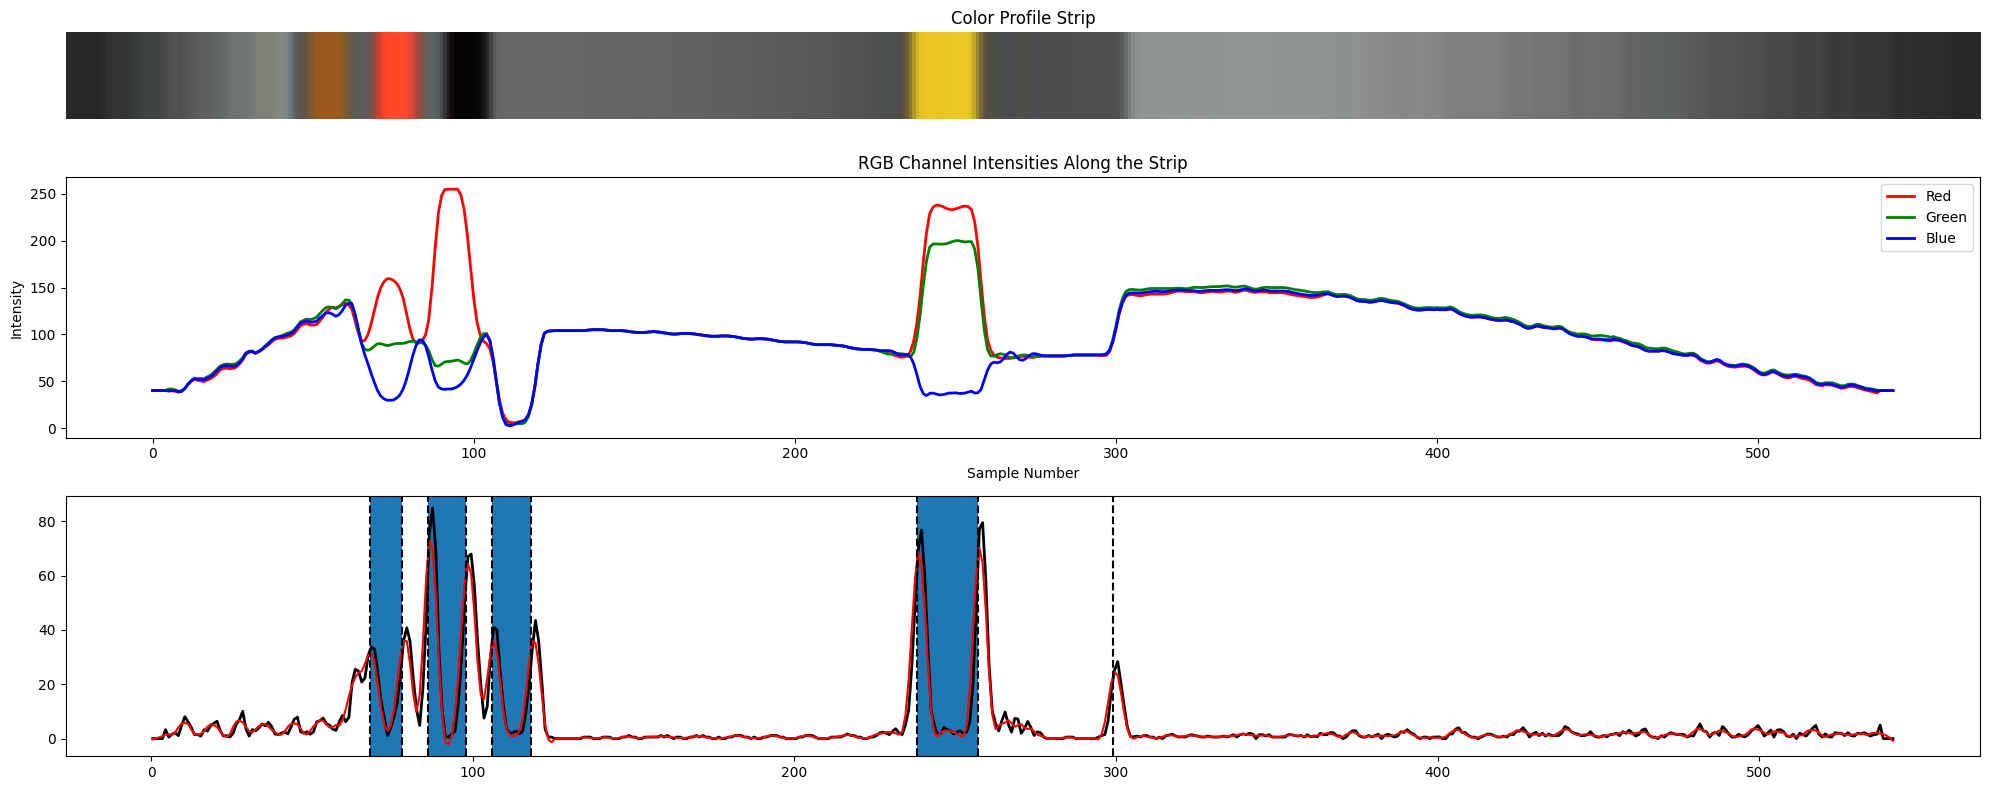

In [5]:
samples = get_points(cv2.imread('images/0000.jpg'))
samples = smoothen(samples, window_size=3)
all_below_15 = np.all(samples < 40, axis=1)
non_removed_idxs = np.where(~all_below_15)[0]
samples = samples[non_removed_idxs[0]:non_removed_idxs[-1] + 1]
samples = np.vstack((np.full((5, 3), 40), samples, np.full((5, 3), 40)))
plot_color_strip(samples)

In [6]:
find_bands(cv2.imread('images/0000.jpg'))

[(array([159.33333333,  88.        ,  29.66666667]), 68, 78),
 (array([255.        ,  71.        ,  41.66666667]), 86, 98),
 (array([5.66666667, 4.        , 3.        ]), 106, 118),
 (array([234.66666667, 196.66666667,  36.33333333]), 238, 257)]

In [7]:
# Read the submission CSV file.
df = pd.read_csv('submission.csv')

# Process only the first 64 rows.
df = df.iloc[:64]
X_train = []
y_train = []
# Iterate over rows in the dataframe.
for _, row in df.iterrows():
    # Skip rows if the 'type' is 'smd' (case-insensitive).
    if str(row['type']).strip().lower() == 'smd':
        continue

    # Collect numeric values from columns 'a', 'b', 'c', 'd', 'e'.
    numeric_values = []
    for col in ['a', 'b', 'c', 'd', 'e']:
        val = str(row[col]).strip()
        try:
            # Attempt to convert to float.
            num = float(val)
            numeric_values.append(num)
        except ValueError:
            # Skip non-numeric entries (e.g., '-' or missing).
            continue

    # Build the image filename based on the id (padded to 4 digits).
    try:
        image_id = int(row['id'])
    except ValueError:
        print(f"Warning: Invalid id value '{row['id']}'")
        continue

    image_path = os.path.join('images', f'{image_id:04d}.jpg')
    
    # Open and process the image.
    try:
        colors = find_bands(cv2.imread(image_path))
        colors = [tuple(t[0]) for t in colors]
    except Exception as e:
        print(f"Warning: Could not process image for row id {row['id']}: {e}")
        continue

    # Check that the number of numeric values equals the number of colors.
    if len(numeric_values) != len(colors):
        print(f"Warning: row id {row['id']} has {len(numeric_values)} numeric values but image produced {len(colors)} colors. Skipping image.")
        continue
        
    for color, number in zip(colors, numeric_values):
        X_train.append(color)
        y_train.append(number)

X_train = np.array(X_train)
y_train = np.array(y_train)
print("Training data loaded.")
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)

Training data loaded.
X_train shape: (197, 3)
y_train shape: (197,)


In [8]:
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=3)

In [9]:
def solve(img):
    bands = [tuple(t[0]) for t in find_bands(img)]
    pred = knn.predict(bands).astype(int)
    while len(pred) < 5: pred.append('-')
    return pred

In [14]:
solve(cv2.imread('images/0000.jpg'))

AttributeError: 'numpy.ndarray' object has no attribute 'append'

In [11]:
import os
from tqdm import tqdm

rows = []
for fname in tqdm(sorted(os.listdir('images'))):
    img = cv2.imread(os.path.join('images', fname))
    try:
        bands = solve(img)
        rows.append({
            'id': os.path.splitext(fname)[0],
            'type': 'axial',
            'a': bands[0],
            'b': bands[1],
            'c': bands[2],
            'd': bands[3],
            'e': bands[4],
        })
    except:
        rows.append({
            'id': os.path.splitext(fname)[0],
            'type': 'smd',
            'a': '-',
            'b': '-',
            'c': '-',
            'd': '-',
            'e': '-',
        })

100%|██████████| 4096/4096 [10:43<00:00,  6.37it/s]


In [12]:
import pandas as pd 
df = pd.DataFrame(rows, columns=['id','type','a','b','c','d','e'])
df.to_csv('sub.csv', index=False)
df.head(5)

,id,type,a,b,c,d,e
0,0000,smd,-,-,-,-,-
1,0001,axial,2,3,7,3,2
2,0002,smd,-,-,-,-,-
3,0003,axial,5,1,0,3,2
4,0004,axial,8,4,1,-1,8


In [2]:
import easyocr
reader = easyocr.Reader(
    ['en'],
    gpu=False,
)

Using CPU. Note: This module is much faster with a GPU.


In [66]:
def autorotate(img):
    th = img
    th = cv2.threshold(th, 10, 255, cv2.THRESH_BINARY)[1]
    cv2.imwrite('04.png', th)
    
    h, w = th.shape
    
    xs, ys = [], []
    for x in range(w):
        col = th[:, x]
        whites = np.where(col == 255)[0]
        if whites.size:
            ys.append(whites.min())   # first white row
            xs.append(x)              # this column
    
    xs = np.array(xs, dtype=np.float32)
    ys = np.array(ys, dtype=np.float32)

    A = np.vstack([xs, np.ones_like(xs)]).T
    (m, b), residuals, rank, s = np.linalg.lstsq(A, ys, rcond=None)
    
    angle = m * 180 / np.pi
    
    M = cv2.getRotationMatrix2D((img.shape[1] / 2, img.shape[0] / 2), angle, scale=1.0)
    return cv2.warpAffine(
        img, M, (img.shape[1], img.shape[0]),
        flags=cv2.INTER_LINEAR,
        borderMode=cv2.BORDER_CONSTANT,
        borderValue=(0, 0, 0)  # black padding
    )

def auto_crop_border(mask, max_iters=10, step=5):
    h, w = mask.shape
    mask[ mask < 20 ] = 0
    top, left, bottom, right = 0, 0, h, w
    
    for i in range(max_iters):
        # crop the outer border strip of width `step`
        top_strip    = mask[top: top+step, left:right]
        bottom_strip = mask[bottom-step: bottom, left:right]
        left_strip   = mask[top:bottom, left: left+step]
        right_strip  = mask[top:bottom, right-step: right]
        
        if (top_strip.sum() or bottom_strip.sum() or
            left_strip.sum() or right_strip.sum()):
            break
        
        # otherwise, shrink the crop window inward
        top    += step
        left   += step
        bottom -= step
        right  -= step
        
        # guard against over‑cropping
        if bottom - top <= step*2 or right - left <= step*2:
            break
    
    return mask[top:bottom, left:right]

def ocr(img):
    img = autorotate(img)
    # img = cv2.flip(img, -1)
    img = auto_crop_border(img, 5, 20)
    cv2.imwrite('04.png', img)
    def run(oimg):
        results = reader.readtext(
            image=oimg,
            detail=1,            # return (bbox, text, conf)
            paragraph=False,
            decoder='greedy',
            allowlist='0123456789R',
            batch_size=1,
        )
        if not results:
            return '', 0.0
        _, text, conf = max(results, key=lambda x: x[2])
        return text, conf
    
    text1, conf1 = run(img)
    flipped = cv2.flip(img, -1)
    text2, conf2 = run(flipped)
    
    return text2 if conf2 > conf1 else text1

In [64]:
img = cv2.imread('images/0000.jpg', cv2.IMREAD_GRAYSCALE)
ocr(img)

''

In [69]:
import os
import re 
from tqdm import tqdm

SMD_PATTERN = re.compile(r'^(\d{3,4}|[0-9]R[0-9])$')

rows = []
for fname in tqdm(sorted(os.listdir('images'))):
    img = cv2.imread(os.path.join('images', fname), cv2.IMREAD_GRAYSCALE)
    result = ocr(img)
    if SMD_PATTERN.match(result):
        rows.append({
            'id': os.path.splitext(fname)[0],
            'type': 'smd',
            'a': result,
            'b': '-',
            'c': '-',
            'd': '-',
            'e': '-',
        })
    else:
        try:
            bands = solve(img)
            rows.append({
                'id': os.path.splitext(fname)[0],
                'type': 'axial',
                'a': bands[0],
                'b': bands[1],
                'c': bands[2],
                'd': bands[3],
                'e': bands[4],
            })
        except:
            rows.append({
                'id': os.path.splitext(fname)[0],
                'type': 'smd',
                'a': '-',
                'b': '-',
                'c': '-',
                'd': '-',
                'e': '-',
            })

  0%|          | 3/4096 [00:04<1:38:02,  1.44s/it]


KeyboardInterrupt: 

In [13]:
import pandas as pd

# Load both CSVs
smd = pd.read_csv('smddd.csv')
sub = pd.read_csv('sub.csv')

# Boolean mask of rows to overwrite
mask = smd['a'] != '-'

# Overwrite in-place in `sub` for those rows
sub.loc[mask, :] = smd.loc[mask, :]

# Save back
sub.to_csv('sub_real.csv', index=False)


In [13]:
import pandas as pd

# Load both CSVs
smd = pd.read_csv('smddd.csv')
sub = pd.read_csv('sub_real.csv')

# Boolean mask of rows to overwrite
mask = (smd['a'] != '-') & (sub['c'] == '-')

# Overwrite in-place in `sub` for those rows
sub.loc[mask, :] = smd.loc[mask, :]

# Save back
sub.to_csv('sub_sus.csv', index=False)
